## 주요 버전, 라이브러리 정보

In [7]:
print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    Versions:    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
print("torch:", "1.9.0")
print("torchvision:", "0.10.0")
print("cv2:", "4.5.2")

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    Versions:    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    
torch: 1.9.0
torchvision: 0.10.0
cv2: 4.5.2


In [8]:
print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    Other Libraries:    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
print("adamp:", "https://github.com/clovaai/AdamP")
print("timm:", "https://github.com/rwightman/pytorch-image-models")

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    Other Libraries:    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    
adamp: https://github.com/clovaai/AdamP
timm: https://github.com/rwightman/pytorch-image-models


## 라이브러리 호출 및 I/O

In [31]:
import os, torch, copy, cv2, sys, random, logging
from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import gc

import matplotlib.pyplot as plt
import json
import pandas as pd
import time
import adamp
from adamp import AdamP

In [14]:
os.getpid()

4005346

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed = 100
seed_everything(seed)

In [17]:
def get_logger(name: str, file_path: str, stream=False) -> logging.RootLogger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s | %(name)s | %(levelname)s | %(message)s')
    stream_handler = logging.StreamHandler()
    file_handler = logging.FileHandler(file_path)

    stream_handler.setFormatter(formatter)
    file_handler.setFormatter(formatter)

    if stream:
        logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    return logger

## Argument Setting

In [18]:
# working directory 지정
ROOT_PATH = './'
TRAIN_DIR = os.path.join(ROOT_PATH, 'train')
RESULT_DIR = os.path.join(ROOT_PATH, 'results')
WEIGHT_DIR = os.path.join(ROOT_PATH, 'weights')
TEST_DIR = os.path.join(ROOT_PATH, 'test')

if not os.path.isdir(RESULT_DIR):
    os.makedirs(RESULT_DIR)

# hyper-parameters
EPOCHS = 20
BATCH_SIZE = 16
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-8
EARLY_STOPPING_PATIENCE = 6
INPUT_SHAPE = (480, 240)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataloader

#### Train & Validation Set loader

In [19]:
class CustomDataset(Dataset):
    def __init__(self, db, mode):

        self.db = db
        self.mode = mode
        self.transform = transforms.Compose([
                                transforms.Resize(INPUT_SHAPE),
                                transforms.RandomHorizontalFlip(p=0.5)])
        
        self.autoaugment = transforms.Compose([
            transforms.RandomApply(nn.ModuleList([
                transforms.AutoAugment()]), p=0.5),
            transforms.ToTensor(), 
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
            

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))
        trans_image = TF.crop(trans_image, 0,0,INPUT_SHAPE[1], INPUT_SHAPE[1])
        trans_image = self.autoaugment(trans_image)
        
        return trans_image, data['label']

    
def data_loader(data_dir=TRAIN_DIR):
    print('Loading ' + ' dataset..')
    if not os.path.isdir(data_dir):
        print(f'!!! Cannot find {data_dir}... !!!')
        sys.exit()
        
    mask_image_list = os.listdir(os.path.join(data_dir, 'Mask'))
    nomask_image_list = os.listdir(os.path.join(data_dir, 'NoMask'))
    mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
    nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
    mask_image_path = list(map(lambda x : os.path.join(data_dir, 'Mask', x), mask_image_list))
    nomask_image_path = list(map(lambda x : os.path.join(data_dir, 'NoMask', x), nomask_image_list))

    # encoding label (Mask : 1, No Mask : 0)
    mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
    nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
    db = mask_df.append(nomask_df, ignore_index=True)
    return db


if os.path.isfile(os.path.join(TRAIN_DIR, 'total.pkl')):
    db = pd.read_pickle(os.path.join(TRAIN_DIR, 'total.pkl'))
else:
    db = data_loader()
    db.to_pickle(os.path.join(TRAIN_DIR, 'total.pkl'))
    
    
# Do stratified split
from sklearn.model_selection import train_test_split

train_idx, valid_idx= train_test_split(
    np.arange(len(db)),
    test_size=0.1,
    shuffle=True,
    stratify=db.label.values,
    random_state=seed)

train_db = db.iloc[train_idx]
valid_db = db.iloc[valid_idx]

train_db = train_db.reset_index()
valid_db = valid_db.reset_index()


transform = transforms.Compose([
                                transforms.Resize(INPUT_SHAPE),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [20]:
train_dataset = CustomDataset(db=train_db, mode='train')
validation_dataset = CustomDataset(db=valid_db, mode='val')

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Train set samples: 24388 Val set samples: 2710


#### Test set Loader

In [21]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        image_list = os.listdir(self.data_dir)
        image_list = [item for item in image_list if item[-4:] == '.png']
        image_path = list(map(lambda x : os.path.join(self.data_dir, x), image_list))
        db = pd.DataFrame({'img_path':image_path, 'file_num':list(map(lambda x : x.split('.')[0], image_list))})
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_num']

In [22]:
transform = transforms.Compose([
                                transforms.Resize(INPUT_SHAPE),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [23]:
test_dataset = TestDataset(data_dir=TEST_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


## Model

In [19]:
# !pip install git+https://github.com/rwightman/pytorch-image-models.git

In [24]:
import timm

In [25]:
NFN_BACKBONES = [
    'dm_nfnet_f2'    
]

In [26]:
# for nfnet
class NFNMaskClassifier(nn.Module):
    def __init__(self, backbone):
        super(NFNMaskClassifier, self).__init__()
        self.model = timm.create_model(backbone, pretrained=True)
        n_features = self.model.head.fc.in_features
        self.model.head.fc = nn.Linear(n_features, 2)

    def forward(self, input_img):
        x = self.model(input_img)
        return x

## SAM Optimizer w. AdamP

In [23]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

# SAM Trainer

In [24]:
class SAM_Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
        
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            loss.backward()
            self.optimizer.first_step(zero_grad=True)
            self.criterion(self.model(img), label).backward()
            self.optimizer.second_step(zero_grad=True)
            
            self.scheduler.step()
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)
    


## Metrics

In [27]:
from sklearn.metrics import accuracy_score, roc_auc_score

def get_metric_fn(y_pred, y_answer, y_prob):
    """ 성능을 반환하는 함수
    """
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    auroc = roc_auc_score(y_answer, y_prob)
    return accuracy, auroc

# Misc.

In [26]:
def plot_loss(train_loss_history, valid_loss_history, backbone):
    plt.plot(train_loss_history, label="train loss")
    plt.plot(valid_loss_history, label="valid loss")
    plt.legend()
    plt.title(backbone)
    plt.show()

def plot_acc(train_acc_history, valid_acc_history, backbone):
    plt.plot(train_acc_history, label="train acc")
    plt.plot(valid_acc_history, label="valid acc")
    plt.legend()
    plt.title(backbone)
    plt.show()

In [27]:
def wait_and_flush():
    
    print("waiting...")
    
    time.sleep(120)
    
    gc.collect()
    torch.cuda.empty_cache()
    print("flushing...")
    time.sleep(60)
    
    gc.collect()
    torch.cuda.empty_cache()
    print("done!")

# 학습 Function

In [28]:
def NFN_train_val_infer(BACKBONE):
    model = NFNMaskClassifier(BACKBONE).to(device)

    base_optimizer = AdamP
    optimizer = SAM(model.parameters(), base_optimizer, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler =  optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=2, eta_min=1e-5, last_epoch=-1)
    
    criterion = nn.CrossEntropyLoss()
    metric_fn = get_metric_fn

    # Set system logger
    system_logger = get_logger(name='train',file_path='train_log.log')

    trainer = SAM_Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)

    train_loss_history = []
    train_acc_history = []

    valid_loss_history = []
    valid_acc_history = []

    best_val_loss = None
    best_val_acc = None
    
    patience = 0
    
    for epoch_index in tqdm(range(EPOCHS)):

        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss_history.append(trainer.train_mean_loss)
        train_acc_history.append(trainer.train_score)

        valid_loss_history.append(trainer.val_mean_loss)
        valid_acc_history.append(trainer.validation_score)

        # don't use early stopper
        patience += 1
        
        if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
            best_val_loss = trainer.val_mean_loss
            patience = 0
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_AA_best.pt'))
        
        if patience == EARLY_STOPPING_PATIENCE:
            break
            
    best_val_acc = max(valid_acc_history)

    plot_loss(train_loss_history, valid_loss_history, BACKBONE)
    plot_acc(train_loss_history, valid_loss_history, BACKBONE)
    
    TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_AA_best.pt')
    
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

    # Prediction
    file_num_lst = []
    pred_lst = []
    prob_lst = []
    model.eval()
    with torch.no_grad():
        for batch_index, (img, file_num) in enumerate(test_dataloader):
            img = img.to(device)
            pred = model(img)
            pred = F.softmax(pred)
            file_num_lst.extend(list(file_num))
            prob_lst.extend(pred[:, 1].cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())

    df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
    df.sort_values(by=['file_name'], inplace=True)
    df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}_SAM_AdamP_AA.csv'), index=False)

# Train and Infer

### NFNet Family

In [29]:
print(NFN_BACKBONES)

['dm_nfnet_f2']


In [30]:
INDEX = 0 #dm_nfnet_f2

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.33163730474188924, Acc: 0.8617352796457274, ROC: 0.9346799673300912
Epoch 0, Val loss: 0.19549998421684878, Acc: 0.9309963099630997, ROC: 0.9805523712821324


  5%|▌         | 1/20 [31:24<9:56:50, 1884.75s/it]

Epoch 1, Train loss: 0.15840050838081035, Acc: 0.9404215187797277, ROC: 0.9860566183743522
Epoch 1, Val loss: 0.12291230852908548, Acc: 0.9553505535055351, ROC: 0.9907835950443851


 10%|█         | 2/20 [1:02:48<9:25:14, 1884.13s/it]

Epoch 2, Train loss: 0.10644307702813686, Acc: 0.9651877972773495, ROC: 0.9939065035780325
Epoch 2, Val loss: 0.09588578556107699, Acc: 0.9715867158671587, ROC: 0.9959234488904147


 15%|█▌        | 3/20 [1:34:07<8:53:11, 1881.86s/it]

Epoch 3, Train loss: 0.08032027357963728, Acc: 0.9746186649171724, ROC: 0.9964627345916963


 20%|██        | 4/20 [2:05:21<8:21:02, 1878.91s/it]

Epoch 3, Val loss: 0.10161923287579647, Acc: 0.9693726937269372, ROC: 0.994011956025633
Epoch 4, Train loss: 0.0706190809826281, Acc: 0.9758487780875841, ROC: 0.9970641351450514
Epoch 4, Val loss: 0.07850316263471466, Acc: 0.9738007380073801, ROC: 0.9962009775920652


 25%|██▌       | 5/20 [2:36:36<7:49:20, 1877.36s/it]

Epoch 5, Train loss: 0.03679752458020842, Acc: 0.9886829588322126, ROC: 0.9992687636408443
Epoch 5, Val loss: 0.06036074588298467, Acc: 0.9789667896678966, ROC: 0.9977535779189695


 30%|███       | 6/20 [3:07:51<7:17:53, 1876.65s/it]

Epoch 6, Train loss: 0.029900376218867958, Acc: 0.9911431851730359, ROC: 0.9994927665286899


 35%|███▌      | 7/20 [3:39:05<6:46:24, 1875.72s/it]

Epoch 6, Val loss: 0.09307378735400174, Acc: 0.9653136531365314, ROC: 0.9952569341772137
Epoch 7, Train loss: 0.04812762606900468, Acc: 0.9833524684270953, ROC: 0.9986300223923074


 40%|████      | 8/20 [4:10:20<6:15:06, 1875.56s/it]

Epoch 7, Val loss: 0.06551411462473798, Acc: 0.9760147601476015, ROC: 0.9970993235098576
Epoch 8, Train loss: 0.04034740723398313, Acc: 0.9864277513531244, ROC: 0.9992450464165413


 45%|████▌     | 9/20 [4:41:35<5:43:46, 1875.12s/it]

Epoch 8, Val loss: 0.08770285801377875, Acc: 0.9756457564575646, ROC: 0.996826253100603
Epoch 9, Train loss: 0.033335633187559666, Acc: 0.9900360833196654, ROC: 0.999295604630692


 50%|█████     | 10/20 [5:12:49<5:12:30, 1875.05s/it]

Epoch 9, Val loss: 0.06658812714795742, Acc: 0.977859778597786, ROC: 0.997144463720367
Epoch 10, Train loss: 0.032224878924646726, Acc: 0.9912661964900771, ROC: 0.9995940549705122


 55%|█████▌    | 11/20 [5:44:05<4:41:16, 1875.16s/it]

Epoch 10, Val loss: 0.08081412250616934, Acc: 0.9726937269372694, ROC: 0.9962132378961541
Epoch 11, Train loss: 0.025945043841213353, Acc: 0.9934804001968182, ROC: 0.9998495844965233


 55%|█████▌    | 11/20 [6:15:19<5:07:04, 2047.20s/it]

Epoch 11, Val loss: 0.0621111037177943, Acc: 0.9804428044280443, ROC: 0.9971205003987385


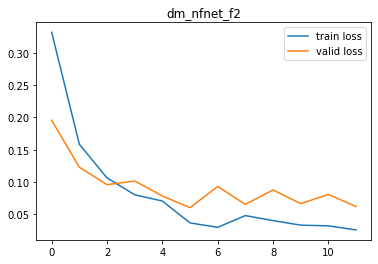

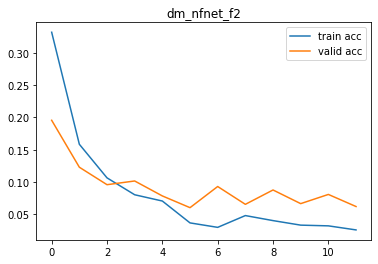

NameError: name 'F' is not defined

In [31]:
NFN_train_val_infer(NFN_BACKBONES[INDEX])